In [2]:
import pm4py
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.dummy import DummyClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

c:\Users\Martin\Desktop\Quarter 2\Advanced Process Mining\Project\process-mining-project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
LOG_FILE = "./BPI_Challenge_2017.xes"
DECISION_POINT = "A_Complete"
TARGET_ACTIVITY = "A_Cancelled"

In [16]:
log = pm4py.read_xes(LOG_FILE)
df = pm4py.convert_to_dataframe(log)

if 'time:timestamp' in df.columns:
    df = df.sort_values(by=['time:timestamp', 'case:concept:name'])

# Find the column names
cols = df.columns.tolist()
score_col = next((c for c in cols if 'Credit' in c or 'score' in c.lower()), None)
# amount_col = next((c for c in cols if 'Amount' in c or 'amount' in c.lower()), None)
terms_col = next((c for c in cols if 'Terms' in c or 'term' in c.lower()), None)

parsing log, completed traces ::  44%|████▎     | 13773/31509 [00:28<01:18, 226.15it/s]

KeyboardInterrupt: 

In [ ]:
log = pm4py.read_xes(LOG_FILE)
df = pm4py.convert_to_dataframe(log)

# SORTING
if 'time:timestamp' in df.columns:
    df = df.sort_values(by=['time:timestamp', 'case:concept:name'])

# Find the correct column names dynamically
cols = df.columns.tolist()
score_col = next((c for c in cols if 'Credit' in c or 'score' in c.lower()), None)
# amount_col = next((c for c in cols if 'Amount' in c or 'amount' in c.lower()), None)
terms_col = next((c for c in cols if 'Terms' in c or 'term' in c.lower()), None)

Loading ./BPI_Challenge_2017.xes...


parsing log, completed traces :: 100%|██████████| 31509/31509 [01:00<00:00, 520.81it/s]


-> Detected Credit Column: 'CreditScore'
-> Detected Amount Column: 'case:RequestedAmount'


In [ ]:
case_groups = df.groupby("case:concept:name")
data_rows = []
labels = []
case_ids = []

unique_activities = df["concept:name"].unique()
act_to_int = {act: i for i, act in enumerate(unique_activities)}

for case_id, group in tqdm(case_groups):
    group = group.sort_values("time:timestamp")
    events = group["concept:name"].tolist()
    timestamps = group["time:timestamp"].tolist()

    # Check Decision Point
    if DECISION_POINT not in events:
        continue

    split_idx = events.index(DECISION_POINT)
    visible_events = events[:split_idx+1]
    
    # Label
    future_events = events[split_idx+1:]
    label = 1 if TARGET_ACTIVITY in future_events else 0

    feature_vector = []

    # --- Credit Score ---
    current_credit = 0.0
    if score_col:
        # Get values up to decision point
        visible_values = group.iloc[:split_idx+1][score_col]
        valid_values = visible_values.dropna()
        if not valid_values.empty:
            # Take the last known valid value
            current_credit = float(valid_values.iloc[-1])
    feature_vector.append(current_credit)

    # --- Offer Count ---
    offer_count = visible_events.count("O_Create Offer")
    feature_vector.append(float(offer_count))

    # --- Processing Time ---
    start_time = timestamps[0]
    decision_time = timestamps[split_idx]
    duration_days = (decision_time - start_time).total_seconds() / 86400.0
    feature_vector.append(duration_days)

    # --- Amount ---
    current_amount = 0.0
    # if amount_col:
    #     visible_values = group.iloc[:split_idx+1][amount_col]
    if terms_col:
        visible_values = group.iloc[:split_idx+1][terms_col]
        valid_values = visible_values.dropna()
        if not valid_values.empty:
            current_amount = float(valid_values.iloc[-1])
    feature_vector.append(current_amount)

    bow_vector = [0] * len(unique_activities)
    for act in visible_events:
        bow_vector[act_to_int[act]] += 1
    feature_vector.extend(bow_vector)

    data_rows.append(feature_vector)
    labels.append(label)
    case_ids.append(case_id)

X = np.array(data_rows)
y = np.array(labels)
case_ids = np.array(case_ids)

print(f"Dataset Ready. Cases: {len(X)}")


100%|██████████| 31509/31509 [00:22<00:00, 1406.60it/s]

Dataset Ready. Cases: 31362


In [ ]:
split = int(len(X) * 0.8)
X_train_raw, X_test_raw = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
test_case_ids = case_ids[split:]

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [ ]:
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
baseline_acc = dummy.score(X_test, y_test)
print(f"\nNaive Baseline (Majority Class): {baseline_acc:.4f}")



Naive Baseline (Majority Class): 0.6697


In [ ]:
# Tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)

# Model
model = nn.Sequential(
    nn.Linear(X.shape[1], 128), 
    nn.ReLU(),
    nn.Dropout(0.3),            
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(64, 1),
    nn.Sigmoid()
)

# Class Weights
count_0 = len(y_train) - y_train.sum()
count_1 = y_train.sum()
pos_weight = torch.tensor([count_0 / count_1]) 

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

print("Training Neural Network...")
dataset = TensorDataset(X_train_t, y_train_t)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

model.train()
loss_history = []
epochs = 50 # Give it enough time to learn
for epoch in range(epochs): 
    epoch_loss = 0
    for xb, yb in loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    loss_history.append(epoch_loss / len(loader))
    
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_history[-1]:.4f}")

Training Neural Network...
Epoch 10/50, Loss: 0.4220
Epoch 20/50, Loss: 0.4203
Epoch 30/50, Loss: 0.4183
Epoch 40/50, Loss: 0.4197
Epoch 50/50, Loss: 0.4193



=== RESULTS ===
Model Accuracy: 0.7366
Improvement over Baseline: 6.70%

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80      4201
           1       0.60      0.63      0.61      2072

    accuracy                           0.74      6273
   macro avg       0.70      0.71      0.71      6273
weighted avg       0.74      0.74      0.74      6273



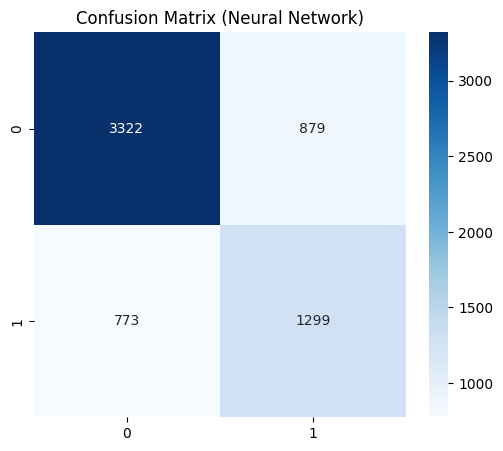

In [ ]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_t).numpy()
    y_pred = (y_pred_probs > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
print(f"\n=== RESULTS ===")
print(f"Model Accuracy: {acc:.4f}")
print(f"Improvement over Baseline: {(acc - baseline_acc)*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Neural Network)")
plt.show()




In [ ]:
# Create DataFrame
analysis_df = pd.DataFrame({
    'CaseID': test_case_ids,
    'Actual': y_test,
    'Predicted': y_pred.flatten(),
    'Probability': y_pred_probs.flatten(),
    'CreditScore': X_test_raw[:, 0], 
    'Amount': X_test_raw[:, 3]       
})

# Check does Credit Score matter?
avg_score_accepted = analysis_df[analysis_df['Predicted']==1]['CreditScore'].mean()
avg_score_rejected = analysis_df[analysis_df['Predicted']==0]['CreditScore'].mean()

print(f"Average Credit Score for Predicted ACCEPT: {avg_score_accepted:.2f}")
print(f"Average Credit Score for Predicted REJECT: {avg_score_rejected:.2f}")

if avg_score_accepted > avg_score_rejected:
    print("-> Insight: The model has correctly learned that higher credit scores lead to acceptance.")
else:
    print("-> Warning: The model is not relying heavily on Credit Score.")

Average Credit Score for Predicted ACCEPT: 0.00
Average Credit Score for Predicted REJECT: 507.57
-> Warning: The model is not relying heavily on Credit Score.
